<a href="https://colab.research.google.com/github/Stan081/ML/blob/main/AML_Week1_MNIST_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
mnist_train = tfds.load(name="mnist", split="train")
assert isinstance(mnist_train, tf.data.Dataset)
print(mnist_train)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


Label: 4


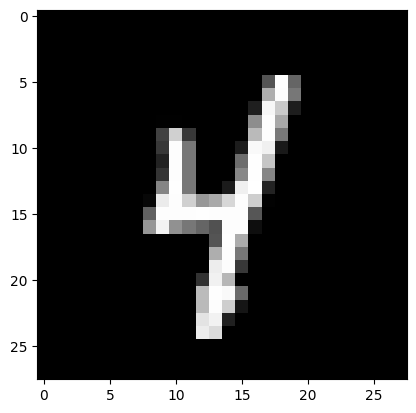

In [ ]:
for mnist_example in mnist_train.take(1):
  image, label = mnist_example["image"], mnist_example['label']

  plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap('gray'))
  print("Label: %d" % label.numpy())

In [ ]:
mnist_builder = tfds.builder("mnist")
mnist_builder.download_and_prepare()
mnist_train = mnist_builder.as_dataset(split='train')
mnist_train

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [ ]:
mnist_train = mnist_train.repeat().shuffle(1024).batch(32)
mnist_train = mnist_train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
info = mnist_builder.info
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [ ]:
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})
10
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
mnist_test, info = tfds.load("mnist", split="test", with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


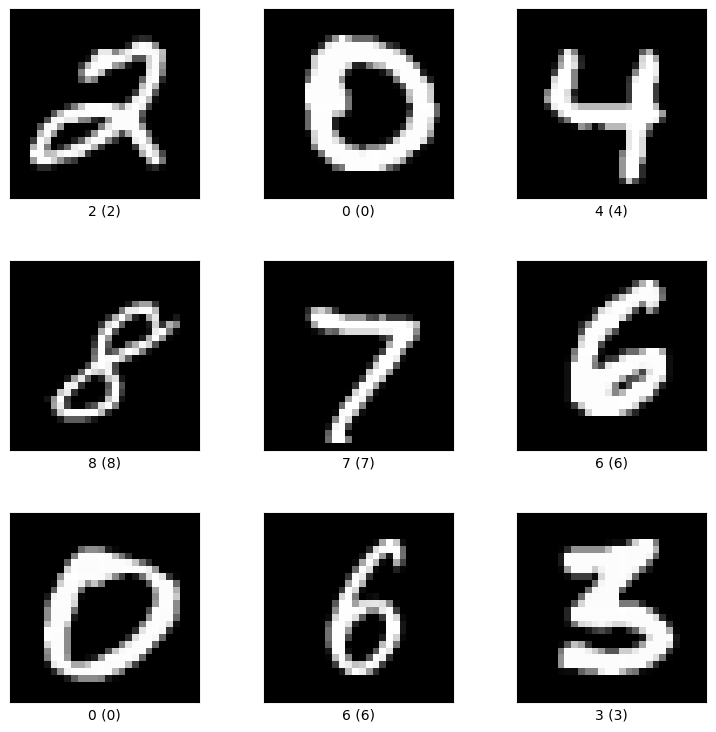

In [ ]:
fig = tfds.show_examples(mnist_test, info)

In [ ]:
mnist_train

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>

In [ ]:
num_classes = 10
num_features = 784
learning_rate = 0.001
training_steps = 500
batch_size = 256
display_step = 100

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

In [ ]:
x_train, x_test = x_train.reshape([-1, num_features]),  x_test.reshape([-1, num_features])

In [ ]:
x_train , x_test =  x_train / 255. , x_test / 255.

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [ ]:
W = tf.Variable(tf.ones([num_features, num_classes]), name="weight")
b = tf.Variable(tf.zeros([num_classes]), name="bias")

In [ ]:
def logistic_regression(x):
  return tf.nn.softmax(tf.matmul(x, W) + b)


In [ ]:
def cross_entopy(y_pred, y_true):
  y_true = tf.one_hot(y_true, depth=num_classes)

  y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
  return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

In [ ]:
def accuracy(y_pred, y_true):
  correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
  return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
optimizer = tf.optimizers.SGD(learning_rate)

In [ ]:

def run_optimization(x, y):
  with tf.GradientTape() as g:
    pred = logistic_regression(x)
    loss = cross_entopy(pred, y)
  gradients = g.gradient(loss, [W, b])
  optimizer.apply_gradients(zip(gradients, [W,b]))


In [ ]:
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
  run_optimization(batch_x, batch_y)

  if step % display_step == 0:
    pred = logistic_regression(batch_x)
    loss = cross_entopy(pred, batch_y)
    acc = accuracy(pred, batch_y)
    print("step: {0}, loss: {1}, accuracy; {2}".format(step, loss, acc))

step: 100, loss: 95.31620025634766, accuracy; 0.9296875
step: 200, loss: 90.46778869628906, accuracy; 0.9140625
step: 300, loss: 103.50730895996094, accuracy; 0.89453125
step: 400, loss: 84.97785949707031, accuracy; 0.90625
step: 500, loss: 85.78093719482422, accuracy; 0.921875


In [ ]:
pred = logistic_regression(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.911500


In [ ]:
n_images = 5
test_images = x_test[:n_images]
predictions = logistic_regression(test_images)

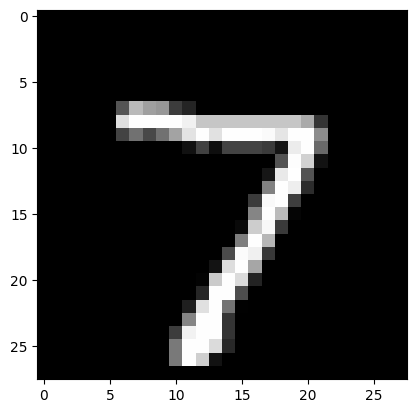

model prediction: 7.000000


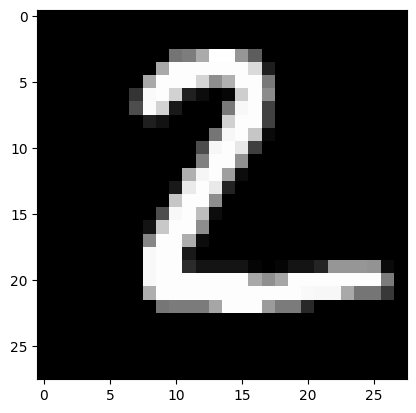

model prediction: 2.000000


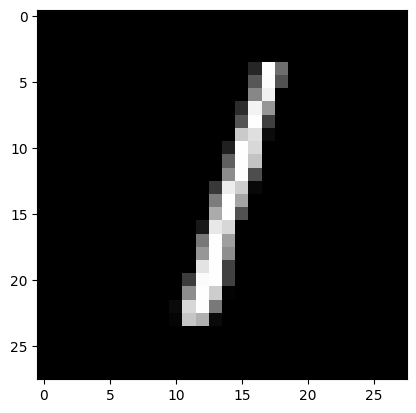

model prediction: 1.000000


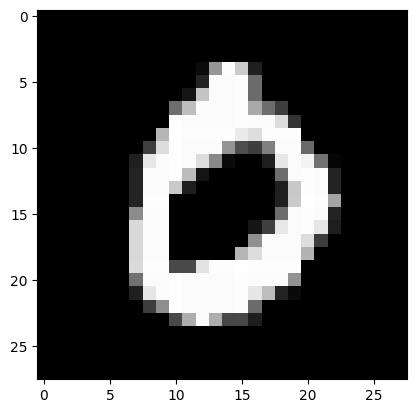

model prediction: 0.000000


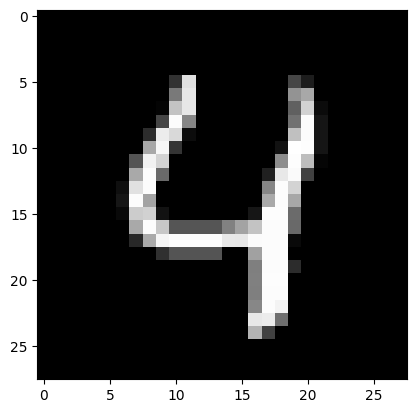

model prediction: 4.000000


In [ ]:
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("model prediction: %f" % np.argmax(predictions.numpy()[i]))